In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

# device = torch.device("mps") if torch.backends.mps.is_available() else (torch.device("cuda" + str(gpu) if torch.cuda.is_available() else "cpu"))
device = 'cpu'

In [2]:
def generate_spiral2d(nspiral=1000,ntotal=500,nsample=100,start=0.,stop=1,noise_std=.1,a=0.,b=1.,savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.

    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check

    Returns: 
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./plots/ground_truth.png', dpi=500)

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts


In [3]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [4]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

Loaded ckpt from ./hulululu/ckpt.pth
Iter: 1, running avg elbo: -111.1599
Iter: 2, running avg elbo: -111.1283
Iter: 3, running avg elbo: -111.0827
Iter: 4, running avg elbo: -111.0482
Stored ckpt at ./hulululu/ckpt.pth
Training complete after 5 iters.


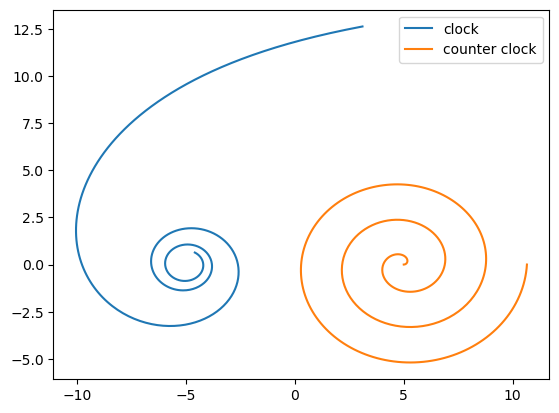

In [5]:
# training parameters
niters = 2000
lr = 0.01
train_dir = "./hulululu/"

# model parameters
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2

# data-generation parameters
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100
# device = torch.device("mps") if torch.backends.mps.is_available() else (torch.device("cuda" + str(gpu) if torch.cuda.is_available() else "cpu"))
device = 'cpu'

# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d( nspiral=nspiral, start=start, stop=stop, noise_std=noise_std, a=a, b=b)
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

if train_dir is not None:
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    ckpt_path = os.path.join(train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        rec.load_state_dict(checkpoint['rec_state_dict'])
        dec.load_state_dict(checkpoint['dec_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        orig_trajs = checkpoint['orig_trajs']
        samp_trajs = checkpoint['samp_trajs']
        orig_ts = checkpoint['orig_ts']
        samp_ts = checkpoint['samp_ts']
        print('Loaded ckpt from {}'.format(ckpt_path))

try:
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
        pred_x = dec(pred_z)

        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(
            samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)
        loss = torch.mean(-logpx + analytic_kl, dim=0)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

except KeyboardInterrupt:
    if train_dir is not None:
        ckpt_path = os.path.join(train_dir, 'ckpt.pth')
        torch.save({
            'func_state_dict': func.state_dict(),
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'orig_ts': orig_ts,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(itr))

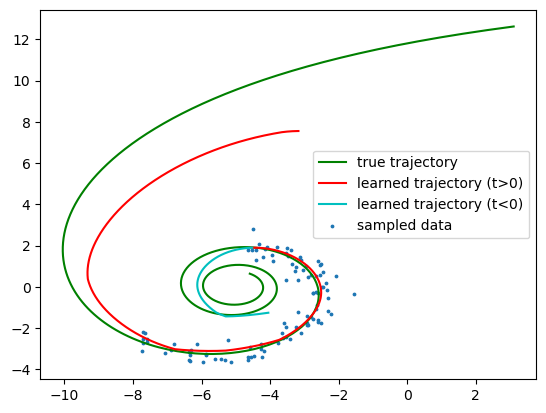

In [6]:
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    orig_ts = torch.from_numpy(orig_ts).float().to(device)

    # take first trajectory for visualization
    z0 = z0[0]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r', label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c', label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[:, 1], label='sampled data', s=3)
plt.legend()
plt.show()